# Text Classification with Preprocessesed text

We are now going to do the exact same exercise as before, but this time we will use preprocessed text. This makes the whole process much simpler.

In [1]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import numpy as np
import seaborn
print(tf.__version__)

2.1.0


We will now load our data. Once again this will come from the IMDB dataset. Note that in future versions these datasets with text encoding will not be available, instead we should use the plain text version and tokenize the text ourselves using 'tensorflow_text'

In [2]:
(train_data, test_data), info = tfds.load(
    # Use the version pre-encoded with an ~8k vocabulary.
    'imdb_reviews/subwords8k', 
    # Return the train/test datasets as a tuple.
    split = (tfds.Split.TRAIN, tfds.Split.TEST),
    # Return (example, label) pairs from the dataset (instead of a dictionary).
    as_supervised=True,
    # Also return the `info` structure. 
    with_info=True)

The info variable has data such as the encoder used to encode the text into tensors. The way the encoder works is by breaking teh input string into a series of characters or phrases that are in its vocabulary. The encoder then assign a number for each of these pieces. Therefore though this is a simple method of encoding, the output vectors from the method are variable length, which is not ideal.

In [3]:
encoder = info.features['text'].encoder

sample_string = "What's up my dudes?"
encoded_string = encoder.encode(sample_string)
print(f"Encoded string is: {encoded_string}")

for ele in encoded_string:
    print(f"{ele} => {encoder.decode([ele])}")

Encoded string is: [1993, 7968, 8, 76, 82, 4660, 190, 7992]
1993 => What
7968 => '
8 => s 
76 => up 
82 => my 
4660 => dud
190 => es
7992 => ?


The data is set of encoded reviews and a label indicating positive or negative sentiment. Let's take a look at its structure a bit better below:

In [4]:
for train_example, train_label in train_data.take(1):
    print('Encoded text:', train_example.numpy())
    print('Label:', train_label.numpy())

Encoded text: [  62   18   41  604  927   65    3  644 7968   21   35 5096   36   11
   43 2948 5240  102   50  681 7862 1244    3 3266   29  122  640    2
   26   14  279  438   35   79  349  384   11 1991    3  492   79  122
  188  117   33 4047 4531   14   65 7968    8 1819 3947    3   62   27
    9   41  577 5044 2629 2552 7193 7961 3642    3   19  107 3903  225
   85  198   72    1 1512  738 2347  102 6245    8   85  308   79 6936
 7961   23 4981 8044    3 6429 7961 1141 1335 1848 4848   55 3601 4217
 8050    2    5   59 3831 1484 8040 7974  174 5773   22 5240  102   18
  247   26    4 3903 1612 3902  291   11    4   27   13   18 4092 4008
 7961    6  119  213 2774    3   12  258 2306   13   91   29  171   52
  229    2 1245 5790  995 7968    8   52 2948 5240 8039 7968    8   74
 1249    3   12  117 2438 1369  192   39 7975]
Label: 0


In [5]:
for train_example, train_label in train_data.take(3):
    print('Encoded text length:', train_example.numpy().size)
    print('Label:', train_label.numpy())

Encoded text length: 163
Label: 0
Encoded text length: 142
Label: 0
Encoded text length: 200
Label: 0


We can see that each encoded tect vector is of a different length. In order to make them all the same length so that the model can handle them, we will simply pad the ends with zeroes. It is important to pad the **ends** as if you pad the front, it will affect the model's learning as the model will not know if the zeroes it encounters are padded or are actually part of the set.

In [6]:
train_data

<PrefetchDataset shapes: ((None,), ()), types: (tf.int64, tf.int64)>

In [7]:
BUFFER_SIZE = 1000

padded_shape = 0

for vector, label in train_data:
    if vector.numpy().size >= padded_shape:
        padded_shape = vector.numpy().size
        
print('Max length is:', padded_shape)

train_batches = (train_data.shuffle(BUFFER_SIZE).padded_batch(32, padded_shapes=((padded_shape,),())))
test_batches = (test_data.padded_batch(32, padded_shapes=((padded_shape,),())))

Max length is: 3944


In [8]:
for example_batch, label_batch in train_batches.take(2):
    print("Batch shape:", example_batch.shape)
    print("label shape:", label_batch.shape)
    

Batch shape: (32, 3944)
label shape: (32,)
Batch shape: (32, 3944)
label shape: (32,)


Now that we have preprocessed our data, and got all our word embeddings padded and ready to go, let us start building our model.


In [9]:
model = tf.keras.Sequential([
    keras.layers.Embedding(encoder.vocab_size, 16),
    keras.layers.GlobalAveragePooling1D(), #creates a fixed length output vector, useful when handling input vectors with varying input lenght
    keras.layers.Dense(1) #standard fully connected nn layer
])

weights = model.get_weights()
reset_model = lambda model:model.set_weights(weights)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          130960    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 130,977
Trainable params: 130,977
Non-trainable params: 0
_________________________________________________________________


Now we can see above that the model has nearly 131k parameters that it can learn and train. The higher the number of parameters, the more a model can learn complex representations and relationships. However, we have to trade off the increase risk of overfitting to the data when the model has such a high number of parameters.

The other factor we must consider are the optimizers and loss function we use. Since this is a binary classification problem, it is appropriate to use a binary crossentropy function, however, we can also use mean squared error loss, which takes into account the distance of a point from the mean of the probability distributions (positive and negative) to give a loss value.

We will compile our model with our loss function and optimizer below:


In [10]:
model.compile(optimizer='adam',
             loss= tf.losses.BinaryCrossentropy(from_logits=True),
             metrics = ['accuracy'])

782/782 [==============================] - 15s 20ms/step - loss: 0.6917 - accuracy: 0.5000 - val_loss: 0.6899 - val_accuracy: 0.4979
[[0.49791667]]


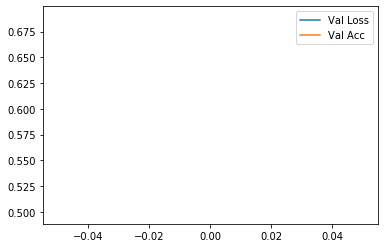

782/782 [==============================] - 16s 20ms/step - loss: 0.6824 - accuracy: 0.5002 - val_loss: 0.6765 - val_accuracy: 0.4990
[[0.49791667], [0.49895832]]


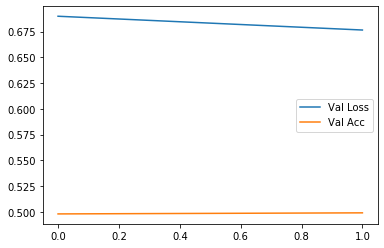

782/782 [==============================] - 16s 20ms/step - loss: 0.6573 - accuracy: 0.5127 - val_loss: 0.6486 - val_accuracy: 0.5208
[[0.49791667], [0.49895832], [0.5208333]]


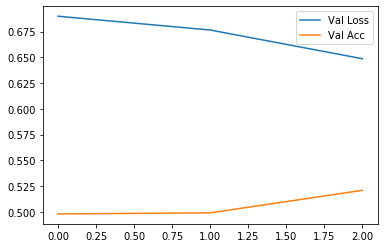

782/782 [==============================] - 21s 27ms/step - loss: 0.6203 - accuracy: 0.5530 - val_loss: 0.6254 - val_accuracy: 0.6760
[[0.49791667], [0.49895832], [0.5208333], [0.67604166]]


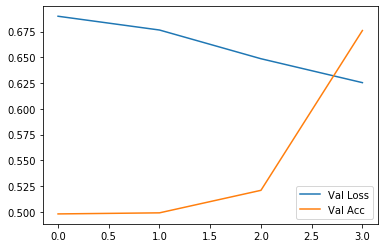

782/782 [==============================] - 26s 34ms/step - loss: 0.5825 - accuracy: 0.6107 - val_loss: 0.5844 - val_accuracy: 0.6385
[[0.49791667], [0.49895832], [0.5208333], [0.67604166], [0.63854164]]


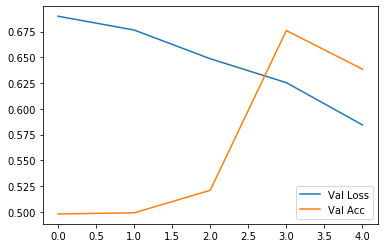

782/782 [==============================] - 26s 33ms/step - loss: 0.5465 - accuracy: 0.6623 - val_loss: 0.5608 - val_accuracy: 0.7510
[[0.49791667], [0.49895832], [0.5208333], [0.67604166], [0.63854164], [0.75104165]]


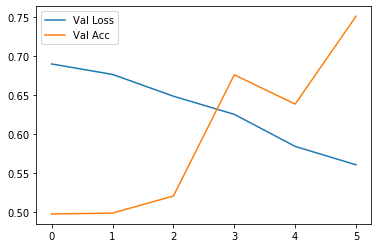

782/782 [==============================] - 23s 29ms/step - loss: 0.5134 - accuracy: 0.7094 - val_loss: 0.5276 - val_accuracy: 0.7115
[[0.49791667], [0.49895832], [0.5208333], [0.67604166], [0.63854164], [0.75104165], [0.7114583]]


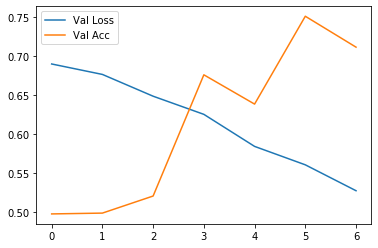

782/782 [==============================] - 22s 28ms/step - loss: 0.4825 - accuracy: 0.7446 - val_loss: 0.5052 - val_accuracy: 0.7823
[[0.49791667], [0.49895832], [0.5208333], [0.67604166], [0.63854164], [0.75104165], [0.7114583], [0.78229165]]


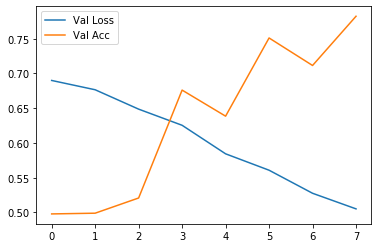

782/782 [==============================] - 22s 28ms/step - loss: 0.4547 - accuracy: 0.7760 - val_loss: 0.4815 - val_accuracy: 0.7844
[[0.49791667], [0.49895832], [0.5208333], [0.67604166], [0.63854164], [0.75104165], [0.7114583], [0.78229165], [0.784375]]


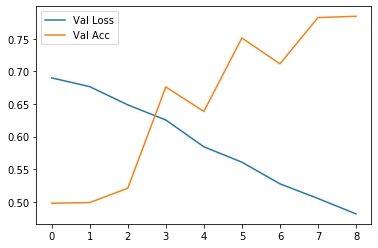

782/782 [==============================] - 23s 29ms/step - loss: 0.4294 - accuracy: 0.7991 - val_loss: 0.4650 - val_accuracy: 0.7427
[[0.49791667], [0.49895832], [0.5208333], [0.67604166], [0.63854164], [0.75104165], [0.7114583], [0.78229165], [0.784375], [0.7427083]]


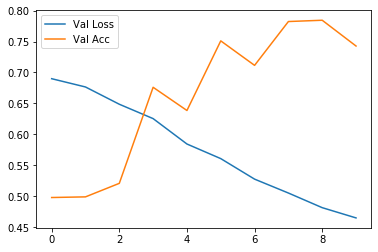

782/782 [==============================] - 24s 31ms/step - loss: 0.4068 - accuracy: 0.8169 - val_loss: 0.4459 - val_accuracy: 0.7698
[[0.49791667], [0.49895832], [0.5208333], [0.67604166], [0.63854164], [0.75104165], [0.7114583], [0.78229165], [0.784375], [0.7427083], [0.76979166]]


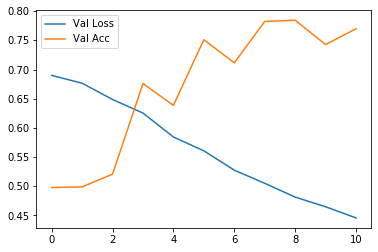

782/782 [==============================] - 23s 30ms/step - loss: 0.3867 - accuracy: 0.8311 - val_loss: 0.4302 - val_accuracy: 0.8240
[[0.49791667], [0.49895832], [0.5208333], [0.67604166], [0.63854164], [0.75104165], [0.7114583], [0.78229165], [0.784375], [0.7427083], [0.76979166], [0.82395834]]


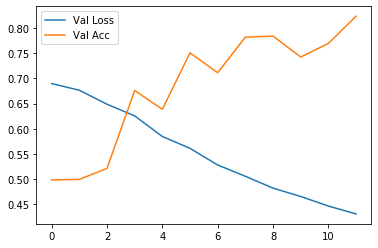

782/782 [==============================] - 22s 29ms/step - loss: 0.3681 - accuracy: 0.8428 - val_loss: 0.4193 - val_accuracy: 0.8510
[[0.49791667], [0.49895832], [0.5208333], [0.67604166], [0.63854164], [0.75104165], [0.7114583], [0.78229165], [0.784375], [0.7427083], [0.76979166], [0.82395834], [0.8510417]]


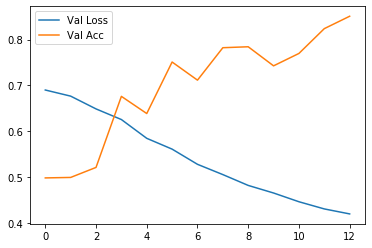

782/782 [==============================] - 22s 28ms/step - loss: 0.3518 - accuracy: 0.8527 - val_loss: 0.4048 - val_accuracy: 0.8406
[[0.49791667], [0.49895832], [0.5208333], [0.67604166], [0.63854164], [0.75104165], [0.7114583], [0.78229165], [0.784375], [0.7427083], [0.76979166], [0.82395834], [0.8510417], [0.840625]]


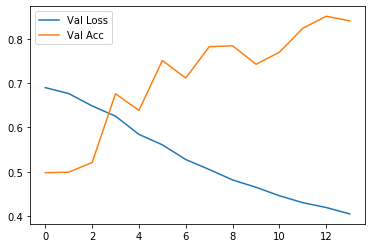

782/782 [==============================] - 22s 28ms/step - loss: 0.3382 - accuracy: 0.8604 - val_loss: 0.3961 - val_accuracy: 0.8292
[[0.49791667], [0.49895832], [0.5208333], [0.67604166], [0.63854164], [0.75104165], [0.7114583], [0.78229165], [0.784375], [0.7427083], [0.76979166], [0.82395834], [0.8510417], [0.840625], [0.82916665]]


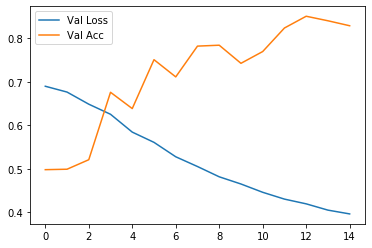

782/782 [==============================] - 24s 30ms/step - loss: 0.3250 - accuracy: 0.8676 - val_loss: 0.3869 - val_accuracy: 0.8385
[[0.49791667], [0.49895832], [0.5208333], [0.67604166], [0.63854164], [0.75104165], [0.7114583], [0.78229165], [0.784375], [0.7427083], [0.76979166], [0.82395834], [0.8510417], [0.840625], [0.82916665], [0.8385417]]


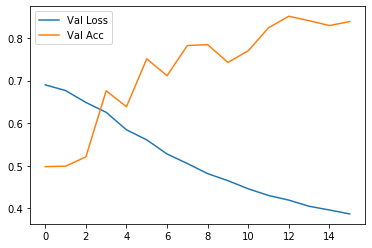

782/782 [==============================] - 23s 30ms/step - loss: 0.3131 - accuracy: 0.8744 - val_loss: 0.3851 - val_accuracy: 0.8219
[[0.49791667], [0.49895832], [0.5208333], [0.67604166], [0.63854164], [0.75104165], [0.7114583], [0.78229165], [0.784375], [0.7427083], [0.76979166], [0.82395834], [0.8510417], [0.840625], [0.82916665], [0.8385417], [0.821875]]


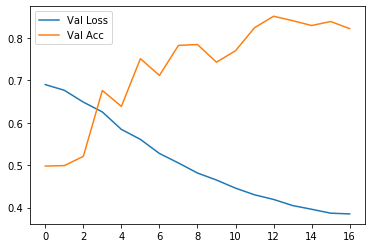

782/782 [==============================] - 23s 30ms/step - loss: 0.3030 - accuracy: 0.8780 - val_loss: 0.3731 - val_accuracy: 0.8490
[[0.49791667], [0.49895832], [0.5208333], [0.67604166], [0.63854164], [0.75104165], [0.7114583], [0.78229165], [0.784375], [0.7427083], [0.76979166], [0.82395834], [0.8510417], [0.840625], [0.82916665], [0.8385417], [0.821875], [0.8489583]]


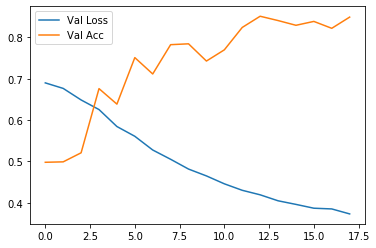

782/782 [==============================] - 25s 31ms/step - loss: 0.2936 - accuracy: 0.8821 - val_loss: 0.3683 - val_accuracy: 0.8479
[[0.49791667], [0.49895832], [0.5208333], [0.67604166], [0.63854164], [0.75104165], [0.7114583], [0.78229165], [0.784375], [0.7427083], [0.76979166], [0.82395834], [0.8510417], [0.840625], [0.82916665], [0.8385417], [0.821875], [0.8489583], [0.84791666]]


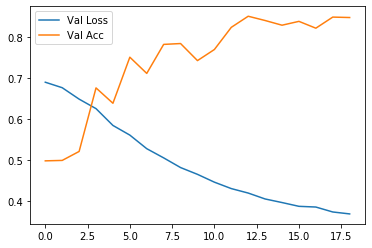

782/782 [==============================] - 24s 30ms/step - loss: 0.2847 - accuracy: 0.8865 - val_loss: 0.3656 - val_accuracy: 0.8438
[[0.49791667], [0.49895832], [0.5208333], [0.67604166], [0.63854164], [0.75104165], [0.7114583], [0.78229165], [0.784375], [0.7427083], [0.76979166], [0.82395834], [0.8510417], [0.840625], [0.82916665], [0.8385417], [0.821875], [0.8489583], [0.84791666], [0.84375]]


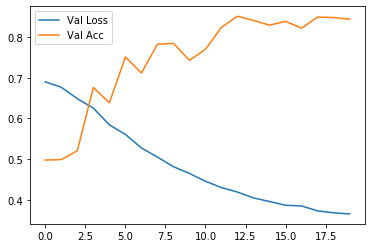

782/782 [==============================] - 22s 29ms/step - loss: 0.2774 - accuracy: 0.8900 - val_loss: 0.3619 - val_accuracy: 0.8604
[[0.49791667], [0.49895832], [0.5208333], [0.67604166], [0.63854164], [0.75104165], [0.7114583], [0.78229165], [0.784375], [0.7427083], [0.76979166], [0.82395834], [0.8510417], [0.840625], [0.82916665], [0.8385417], [0.821875], [0.8489583], [0.84791666], [0.84375], [0.86041665]]


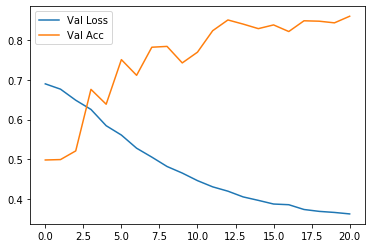

782/782 [==============================] - 23s 29ms/step - loss: 0.2700 - accuracy: 0.8933 - val_loss: 0.3553 - val_accuracy: 0.8625
[[0.49791667], [0.49895832], [0.5208333], [0.67604166], [0.63854164], [0.75104165], [0.7114583], [0.78229165], [0.784375], [0.7427083], [0.76979166], [0.82395834], [0.8510417], [0.840625], [0.82916665], [0.8385417], [0.821875], [0.8489583], [0.84791666], [0.84375], [0.86041665], [0.8625]]


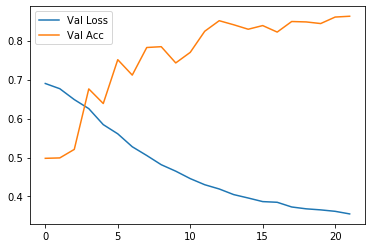

782/782 [==============================] - 24s 30ms/step - loss: 0.2635 - accuracy: 0.8961 - val_loss: 0.3521 - val_accuracy: 0.8635
[[0.49791667], [0.49895832], [0.5208333], [0.67604166], [0.63854164], [0.75104165], [0.7114583], [0.78229165], [0.784375], [0.7427083], [0.76979166], [0.82395834], [0.8510417], [0.840625], [0.82916665], [0.8385417], [0.821875], [0.8489583], [0.84791666], [0.84375], [0.86041665], [0.8625], [0.86354166]]


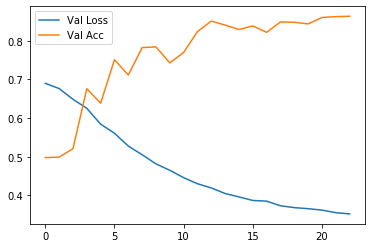

In [12]:
reset_model(model)
epochs = 22
import matplotlib.pyplot as plt
%matplotlib inline

val_loss = []
val_acc = []
best_acc = 0
best_weights = []


for e in range(epochs+1):
    history = model.fit(train_batches,
                        validation_data=test_batches,
                        validation_steps=30)
    val_loss.append(history.history['val_loss'])
    val_acc.append(history.history['val_accuracy'])
    print(val_acc)
    
    if val_acc[e][0] > best_acc:
        best_acc = val_acc[e]
        best_weights = model.get_weights()
        
    plt.plot(val_loss, label='Val Loss')
    plt.plot(val_acc, label='Val Acc')
    plt.legend()
    plt.show()
    
    

In [13]:
val_acc.index(max(val_acc))

22

In [15]:
model.set_weights(best_weights)

loss, accuracy = model.evaluate(test_batches)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

    782/Unknown - 14s 17ms/step - loss: 0.3221 - accuracy: 0.8695Loss:  0.32207821059943464
Accuracy:  0.86952


Look at this brilliance! We have been able to do our movie review thing again. But this time with the preprocessed text.